In [ ]:
!pip install gym[atari]

In [1]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import random
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Create environment

In [3]:
env = gym.make('CartPole-v0')
env.seed(42)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
action_size = env.action_space.n

Observation space: Box(4,)
Action space: Discrete(2)


Hyperparameters

In [4]:
eps = np.finfo(np.float32).eps.item()

# Choose action with policy network

In [14]:
def choose(state,actor_model):
  prediction = actor_model.predict(state)[0]
  action = np.random.choice(action_size, p=prediction)
  return action

# Declare Actor and Critic

In [13]:
def init_ActorNetwork(input_shape,lr):
  inputs = layers.Input(shape=(4,))
  middle = layers.Dense(128, activation="relu")(inputs)
  actor = layers.Dense(2, activation="softmax")(middle)
  model = keras.Model(inputs=inputs, outputs=actor)
  return model
        
   
            

In [12]:
def init_CriticNetwork(input_shape,lr):
  inputs = layers.Input(shape=(4,))
  middle = layers.Dense(128, activation="relu")(inputs)
  critic = layers.Dense(1)(middle)
  model = keras.Model(inputs=inputs, outputs=critic)
  return model

In [8]:
def discount_rewards(reward):
        
        gamma = 0.99 
        returns = [x*0 for x in range(len(reward))]
        discounted_sum = 0
        for r in reversed(range(0,len(reward))):
            discounted_sum = reward[r] + gamma * discounted_sum
            returns[r] = discounted_sum
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()
        return returns

# Train using  A2C

Episode Reward0 13.0
Episode Reward1 13.0
Episode Reward2 20.0
Episode Reward3 34.0
Episode Reward4 21.0
Episode Reward5 17.0
Episode Reward6 19.0
Episode Reward7 15.0
Episode Reward8 21.0
Episode Reward9 46.0
Episode Reward10 33.0
Episode Reward11 15.0
Episode Reward12 28.0
Episode Reward13 14.0
Episode Reward14 33.0
Episode Reward15 26.0
Episode Reward16 44.0
Episode Reward17 15.0
Episode Reward18 57.0
Episode Reward19 30.0
Episode Reward20 58.0
Episode Reward21 115.0
Episode Reward22 32.0
Episode Reward23 26.0
Episode Reward24 44.0
Episode Reward25 25.0
Episode Reward26 67.0
Episode Reward27 69.0
Episode Reward28 40.0
Episode Reward29 42.0
Episode Reward30 53.0
Episode Reward31 200.0
Episode Reward32 124.0
Episode Reward33 200.0
Episode Reward34 194.0
Episode Reward35 130.0
Episode Reward36 121.0
Episode Reward37 87.0
Episode Reward38 141.0
Episode Reward39 163.0
Episode Reward40 200.0
Episode Reward41 200.0
Episode Reward42 200.0
Episode Reward43 200.0
Episode Reward44 87.0
Episode

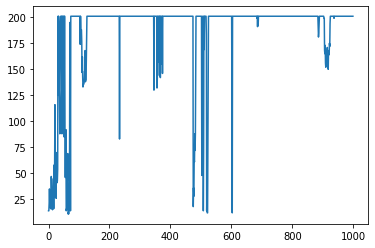

In [10]:
import math
optimizer = keras.optimizers.Adam(learning_rate=0.01)
actor_model=init_ActorNetwork(4,0.01)
critic_model=init_CriticNetwork(4,0.01)
rewards=[]
actions=[]
max_average=-100
huber_loss = keras.losses.Huber()
running_reward=0

reward_per_episode_array=[]
for episode in range(1000):
  step = 0
  states, actions,rewards = [], [], []
  reward_per_episode=0
  state = env.reset()
  predicted_values=[]
  past_probs=[]
  done=False
  with tf.GradientTape(persistent=True) as tape:
    while not done: 
      step += 1
      state = tf.convert_to_tensor(state)
      state = tf.expand_dims(state, 0)
      
      critic_value = critic_model(state)
      predicted_values.append(critic_value[0, 0])

      action_probs=actor_model(state)
      action = np.random.choice(2, p=np.squeeze(action_probs))
      
      past_probs.append(tf.math.log(action_probs[0, action]))

      state, reward, done, _ = env.step(action)
      rewards.append(reward)
      reward_per_episode=reward+reward_per_episode
      if done == True:
        print("Episode Reward"+str(episode)+" "+str(reward_per_episode))
    
    returns=discount_rewards(rewards)
    actor_losses =0
    critic_losses =0
    for i in range(len(rewards)):
        diff = returns[i] - predicted_values[i]
        actor_losses=actor_losses+(-past_probs[i] * diff)
        critic_losses=critic_losses+huber_loss(tf.expand_dims(predicted_values[i], 0), tf.expand_dims(returns[i], 0))

   
    act_grads = tape.gradient(actor_losses, actor_model.trainable_variables)
    optimizer.apply_gradients(zip(act_grads, actor_model.trainable_variables))

    
    cr_grads = tape.gradient(critic_losses, critic_model.trainable_variables)
    optimizer.apply_gradients(zip(cr_grads, critic_model.trainable_variables))

    past_probs.clear()
    predicted_values.clear()
    rewards.clear()

  

          

  reward_per_episode_array.append(reward_per_episode + 1)
  

  
  
print(reward_per_episode_array, file=open("./gdrive/My Drive/A2C/rewards_per_episode.txt", "a"))
plt.plot(reward_per_episode_array)



[113.2, 115.07, 117.01, 118.95, 120.48, 122.23, 123.81, 125.58, 127.36, 129.27, 130.55, 131.8, 133.24, 134.43, 135.9, 136.82, 138.08, 138.7, 140.32, 140.85, 142.3, 143.75, 143.44, 144.43, 145.73, 146.49, 148.23, 149.4, 150.42, 152.04, 153.73, 156.67, 155.91, 157.43, 157.37, 156.79, 157.4, 157.85, 159.52, 160.33, 161.07, 161.07, 161.07, 161.07, 159.94, 162.2, 162.2, 162.2, 162.2, 162.2, 162.2, 161.04, 163.36, 163.36, 162.25, 162.92, 164.84, 166.11, 166.42, 168.31, 170.15, 172.41, 173.75, 175.59, 176.33, 178.24, 180.12, 182.03, 183.96, 186.35, 188.91, 188.48, 187.71, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.45, 191.18, 191.72, 191.59, 191.72, 191.85, 191.87, 191.81, 192.5, 192.7, 193.18, 193.88, 194.55, 195.2, 195.87, 196.6, 197.12, 197.87, 197.9, 198.54, 199.17, 199.96, 200.64, 201.0, 20

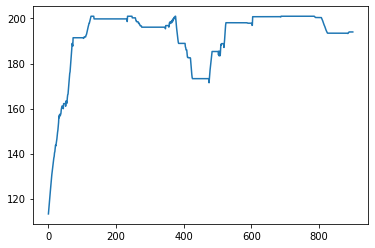

In [11]:
count=0
avg_array=[]
for i in range(len(reward_per_episode_array)):
  if (count==9):
    avg_array.append(addition/10)
    count=0
  if(count==0):
    addition=0
    count+=1
  else:
    addition=addition+reward_per_episode_array[i]
    count+=1

avg_array=[]
for i in range(len(reward_per_episode_array)):
  addition=0
  if(i<(len(reward_per_episode_array)-99)):
    addition=reward_per_episode_array[i]
    for j in range (i,i+99):
      addition+=reward_per_episode_array[j]
    avg_array.append(addition/100)

print (avg_array)
plt.plot(avg_array)